In [1]:
import numpy as np
import pandas as pd
import torch
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"  # type:ignore

In [ ]:
x = torch.arange(12, dtype=torch.float32)
x
x.shape
X = x.reshape(3, 4)
X
df = pd.DataFrame({"1": [1, 2, 3]})
x.numel()


tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

torch.Size([12])

tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.]])

12

# autograd example

In [ ]:
a = torch.arange(3).reshape([1, 3])
a.tolist()

[[0, 1, 2]]

In [ ]:
x = torch.arange(4.0, requires_grad=True)
y = 2 * x
y.sum().backward()
x.grad
#  report error
# y.sum().backward()
# x.grad

assert x.grad is not None
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x
y.detach()
z.sum().backward()
x.grad


tensor([2., 2., 2., 2.])

tensor([0., 0., 0., 0.])

tensor([0., 1., 4., 9.])

In [3]:
def f(a):
    b = a * 2
    if b >= 0:
        b = b * 2
    return b


# a = torch.randn(size=(), requires_grad=True)
a = torch.zeros(size=(), requires_grad=True)
z = f(a)
z.backward()
a.grad


NameError: name 'torch' is not defined

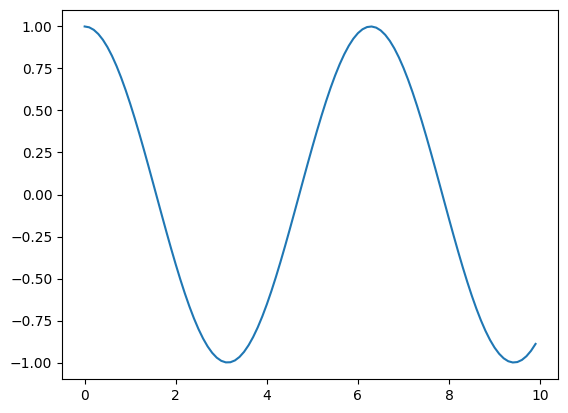

In [ ]:
# q5

x = torch.arange(0, 10, 0.1, requires_grad=True)
y = torch.sin(x)
y.sum().backward()

import matplotlib.pyplot as plt

plt.plot(x.detach().numpy(), x.grad.detach().numpy())


In [2]:
for i in range(101):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


# linear regression implementation

* implemnet linear regression from scratch

In [6]:
%matplotlib inline
import random

import d2l.d2l as d2l
import matplotlib.pyplot as plt
import pandas as pd
import structlog
import torch

logger = structlog.get_logger()


2026-02-01 00:32:43 [info     ] generate data                 
features tensor([0.9623, 2.5510]) 
label tensor([-2.5586])
2026-02-01 00:32:43 [info     ] plot data                     


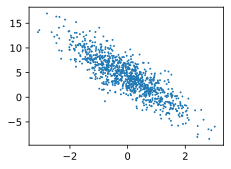

2026-02-01 00:32:43 [info     ] adding data iter              
tensor([[ 0.2775, -2.0097],
        [ 0.2511, -0.4963],
        [ 0.0101, -0.5512],
        [-1.1046, -0.0419],
        [-1.4247, -0.0102],
        [-0.2410,  1.2057],
        [-0.3847,  1.1356],
        [-1.6271, -1.9711],
        [-0.7472,  0.0760],
        [ 0.1648,  0.2672]])
tensor([[11.6140],
        [ 6.3967],
        [ 6.1102],
        [ 2.1396],
        [ 1.3980],
        [-0.3835],
        [-0.4450],
        [ 7.6556],
        [ 2.4481],
        [ 3.6204]])
2026-02-01 00:32:43 [info     ] init parameter                
2026-02-01 00:32:43 [info     ] define model                  
2026-02-01 00:32:43 [info     ] training                      
2026-02-01 00:32:43 [info     ] loss                           epoch=1 loss=0.03354
2026-02-01 00:32:43 [info     ] loss                           epoch=2 loss=0.00012
2026-02-01 00:32:43 [info     ] loss                           epoch=3 loss=0.00005
2026-02-01 00:32:43 [inf

tensor([0.0001, 0.0003], grad_fn=<DivBackward0>)

tensor([-2.6113e-06], grad_fn=<DivBackward0>)

In [37]:
def synthetic_data(
    w: torch.Tensor,
    b: torch.Tensor,
    n_sample,
):
    # w (len(w)), b scalar
    X = torch.normal(0.0, 1.0, (n_sample, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, (n_sample,))
    return X, y.reshape([-1, 1])


logger.info("generate data")
true_w = torch.tensor([2, -3.4])
true_b = torch.tensor(4.2)
features, labels = synthetic_data(true_w, true_b, n_sample=1000)

print("features", features[0], "\nlabel", labels[0])

logger.info("plot data")

d2l.set_figsize()

plt.scatter(
    x=features[:, 1].detach().numpy(),
    y=labels.detach().numpy(),
    s=1,
)
plt.show()

logger.info("adding data iter")


def data_iter(
    batch_size: int,
    features: torch.Tensor,
    labels: torch.Tensor,
):
    n_sample = len(features)
    idx = list(range(n_sample))
    random.shuffle(idx)
    for i in range(0, n_sample, batch_size):
        batch_idx = torch.tensor(idx[i : min(i + batch_size, n_sample)])
        yield features[batch_idx, :], labels[batch_idx]


batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X)
    print(y)
    break

logger.info("init parameter")
# w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
w = torch.zeros(size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)


logger.info("define model")


def ols(X, w, b):
    return torch.matmul(X, w) + b


def square_loss(y_hat, y):
    return (y.reshape(y_hat.shape) - y_hat) ** 2 / 2


def sgd(
    para: list[torch.Tensor],
    lr: float,
    batch_size: int,
):
    with torch.no_grad():
        for _para in para:
            assert _para.grad is not None
            # works by updating variable in place.
            _para -= lr * _para.grad / batch_size
            _para.grad.zero_()


logger.info("training")

lr = 0.03
n_epoch = 3
net = ols
loss = square_loss

for epoch in range(n_epoch):
    for X, y in data_iter(batch_size, features, labels):
        _loss = loss(net(X, w, b), y)
        _loss.sum().backward()
        sgd([w, b], lr, batch_size)

    # print losss
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        logger.info("loss", epoch=epoch + 1, loss=f"{train_l.mean().item():.5f}")

logger.info("compare estimated para vs true para")
display((true_w - w.reshape([-1])) / true_w)
display((true_b - b) / true_b)


### implement linear reg using torch

In [49]:
# import numpy as np
import torch
from torch.utils import data

logger.info("use pytorch data iterator")

true_w = torch.tensor([2, -3.4])
true_b = torch.tensor(4.2)
features, labels = synthetic_data(true_w, true_b, n_sample=1000)


def load_array(
    data_array: tuple[torch.Tensor, torch.Tensor],
    batch_size: int,
    is_train: bool = True,
):
    dataset = data.TensorDataset(*data_array)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)


batch_size = 10
data_iter = load_array(
    (features, labels),
    batch_size,
)
print(next(iter(data_iter)))


logger.info("build model")

from torch import nn

nn.Linear(2, 1).weight.data
net = nn.Sequential(nn.Linear(2, 1))
# init parameters
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.01)

n_epoch = 3
for epoch in range(n_epoch):
    for X, y in data_iter:
        _loss = loss(net(X), y)
        trainer.zero_grad()
        _loss.backward()
        trainer.step()
    with torch.no_grad():
        _l = loss(net(features), labels)
        logger.info("train set loss", epoch=epoch, loss=_l)

logger.info("verify parameter estimated")

w = net[0].weight.data
logger.info("w estimate error")
display(true_w - w.reshape(true_w.shape))
logger.info("b estimate error")
b = net[0].bias.data
display(true_b - b)
display(net[0].weight.grad)

2026-02-01 01:06:50 [info     ] use pytorch data iterator     
[tensor([[ 1.1349, -0.2437],
        [-1.4403, -0.1152],
        [ 0.1464,  0.3752],
        [-1.0880, -1.7849],
        [-0.0123,  0.3806],
        [-0.4135, -1.5862],
        [-1.0272,  0.9447],
        [ 0.3790,  1.0791],
        [ 2.0210,  0.9197],
        [ 0.4832, -0.6845]]), tensor([[ 7.3008],
        [ 1.7075],
        [ 3.2246],
        [ 8.0818],
        [ 2.9002],
        [ 8.7728],
        [-1.0807],
        [ 1.2811],
        [ 5.1234],
        [ 7.4916]])]
2026-02-01 01:06:50 [info     ] build model                   
2026-02-01 01:06:50 [info     ] train set loss                 epoch=0 loss=tensor(0.7364)
2026-02-01 01:06:50 [info     ] train set loss                 epoch=1 loss=tensor(0.0182)
2026-02-01 01:06:50 [info     ] train set loss                 epoch=2 loss=tensor(0.0006)
2026-02-01 01:06:50 [info     ] verify parameter estimated    
2026-02-01 01:06:50 [info     ] w estimate error              


tensor([ 0.0043, -0.0160])

2026-02-01 01:06:50 [info     ] b estimate error              


tensor([0.0156])

tensor([[0.0099, 0.0156]])

torch.Size([1000, 2])